 # Import Libraries and Dependencies

In [1]:
# Install necessary libraries
!pip install -q nltk
!pip install -q autocorrect
!pip install -q wordcloud
!pip install -q tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from autocorrect import Speller
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from google.colab import files


 # Download and Set Up NLTK Resources

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

 # Mount Google Drive (if using Google Colab)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')


# Download Kaggle Dataset

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"surajsutradhar","key":"f3d5d1c415d1a0ec6878c9dbed5fc823"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!pip install -q kaggle

In [8]:
!kaggle competitions download -c fake-news

fake-news.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip fake-news.zip

Archive:  fake-news.zip
replace submit.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

 # Load Dataset

In [10]:
df = pd.read_csv('train.csv')
df = df.dropna()


 # Data Preprocessing Functions

In [11]:
# Initialize Lemmatizer, Stemmer, and Spell Checker
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
spell = Speller(lang='en')

# Text Preprocessing Functions
def lower_text(text):
    return str(text).lower()

def remove_stopwords(text):
    stoplist = stopwords.words('english')
    return " ".join([word for word in text.split() if word not in stoplist])

def lemmatization(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def autospell(text):
    return " ".join([spell(word) for word in text.split()])

def stem_sentence(sentence):
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) + " " for word in token_words]
    return "".join(stem_sentence)

# Function to Build Corpus
def get_corpus(sentence):
    corpus = []
    token_words = word_tokenize(sentence)
    for word in token_words:
        corpus.append(word)
    return sentence


In [12]:
# stopwords.words('english')

 # Apply Preprocessing to Dataset

In [13]:
df['text'] = df['text'].apply(lower_text)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(lemmatization)
df['text'] = df['text'].apply(get_corpus)

# Drop Empty Text Rows
df = df[df['text'].str.len() > 2].sample(frac=1).reset_index(drop=True)


 # Exploratory Data Analysis (EDA)

<ipython-input-14-f08234fed9be>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette='Set1')


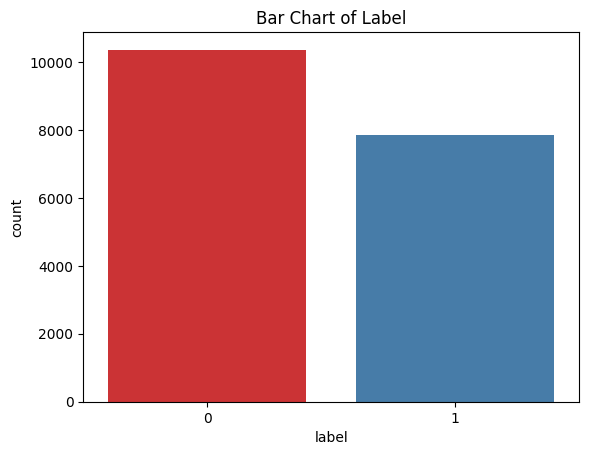

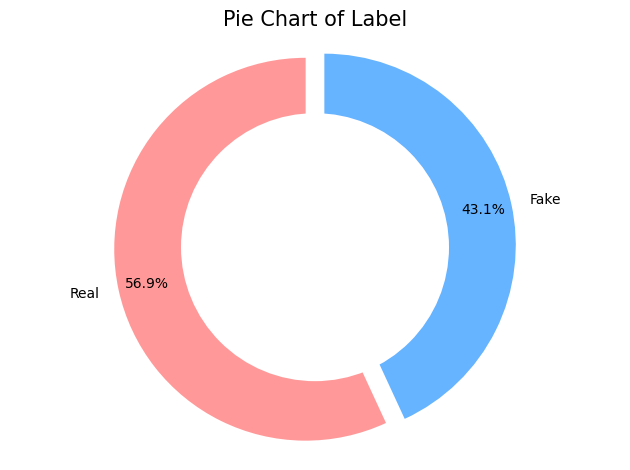

In [14]:
# Plotting Distribution of Labels
ax = sns.countplot(x='label', data=df, palette='Set1')
ax.set_title("Bar Chart of Label")

# Pie Chart of Labels
labels = ['Real', 'Fake']
values = df['label'].value_counts()
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0.05)
fig1, ax1 = plt.subplots()
plt.pie(values, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
ax1.set_title("Pie Chart of Label", fontdict={'fontsize': 15, 'fontweight': 10}, loc='center')
plt.tight_layout()
plt.show()


 # Word Cloud Analysis

In [ ]:
# Word Cloud for All Text
text = " ".join(text for text in df['text'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Word Cloud for Fake News
text_fake = " ".join(text for text in df[df['label'] == 1]['text'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text_fake)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Word Cloud for Real News
text_real = " ".join(text for text in df[df['label'] == 0]['text'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text_real)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


 # Feature Engineering

In [ ]:
# Vectorization
tf_vectorizer = HashingVectorizer()
X_tf = tf_vectorizer.fit_transform(df['text'])
y = df['label']

# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size=0.33, random_state=42)


# Machine Learning Models

## Model 1: Multinomial Naive Bayes

In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)
y_pred = naive_bayes_classifier.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))


## Model 2: Support Vector Classifier (SVC)

In [ ]:
svc_classifier = SVC(gamma='auto')
svc_classifier.fit(X_train, y_train)
y_pred = svc_classifier.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))


## Model 3: Decision Tree Classifier

In [ ]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)
y_pred = decision_tree_classifier.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))


## Model 4: Logistic Regression

In [ ]:
logistic_regression_classifier = LogisticRegression()
logistic_regression_classifier.fit(X_train, y_train)
y_pred = logistic_regression_classifier.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))


# Deep Learning Models

## Model 1: Multi-Layer Perceptron(MLP) Classifier

In [ ]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, y_train)
y_pred = mlp_classifier.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))


## Model 2: LSTM on Tokenized Text

In [ ]:
max_features = 348
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
tokenizer.fit_on_texts(df['text'])
X_seq = tokenizer.texts_to_sequences(df['text'])
X_pad = pad_sequences(X_seq, padding='post')

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_pad, y, test_size=0.33, random_state=42)

# Building LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(max_features, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the Model
model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=64, validation_split=0.2)
score = model.evaluate(X_test_seq, y_test_seq)
print("LSTM Accuracy:", score[1])
